In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import random

In [2]:
def get_data():
    p = 0.02
    names = [i for i in range(785)]
    dataset = pd.read_csv('A_Z Handwritten Data.csv', names=names,skiprows=lambda i: i>0 and random.random() > p)
    X = dataset.loc[:,1:]
    X = X/255
    Y = dataset.loc[:,0]
    enc = OneHotEncoder()
    Y = enc.fit_transform(np.array(Y).reshape(-1,1))
    #print(Y.toarray().shape)
    #print(type(Y.toarray()))
    # split the data into training (80%) and testing (20%)
    (X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.20)
    return X_train.values, X_test.values, Y_train.toarray(), Y_test.toarray()

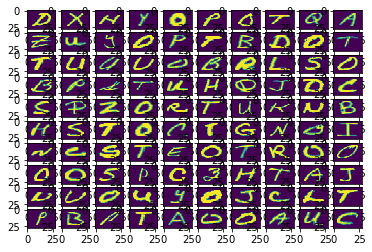

In [3]:
def visualize_data():
    X_train, X_test ,Y_train, Y_test  = get_data()
    # visualize data by plotting images 
    fig,ax = plt.subplots(10,10) 
    k = 0
    for i in range(10): 
        for j in range(10): 
            ax[i][j].imshow(X_train[k].reshape(28,28), aspect='auto') 
            k += 1
    plt.show() 

visualize_data()

In [4]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) 

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')


In [5]:
epochs = 20
learning_rate = 0.01 
batch_size = 128
    

In [6]:
n_input = 28
n_classes = 26

In [7]:
x = tf.placeholder("float", [None, 28,28,1])
y = tf.placeholder("float", [None, n_classes])

In [8]:
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W6', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(26), initializer=tf.contrib.layers.xavier_initializer()),
}

In [9]:
def conv_net(x, weights, biases):  

    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)

    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv3 = maxpool2d(conv3, k=2)


    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out


In [10]:
pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [11]:
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()

In [12]:
X_train, X_test ,Y_train, Y_test  = get_data()
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

In [13]:
sess = tf.Session()
sess.run(init) 
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
summary_writer = tf.summary.FileWriter('./Output', sess.graph)
for e in range(0,epochs):
    #shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(Y_train)))
    X_train = X_train[shuffle_indices]
    Y_train = Y_train[shuffle_indices]

    #minibatch training
    for i in range(0,len(Y_train)//batch_size):
        start = i*batch_size
        batch_x = X_train[start:start+batch_size]
        batch_y = Y_train[start:start+batch_size]
            
        #run optimizer
        sess.run(optimizer,feed_dict={x:batch_x,y:batch_y}) 
            
    ts_loss,test_acc = sess.run([cost,accuracy], feed_dict={x: X_test,y : Y_test})
    tr_loss,train_acc = sess.run([cost,accuracy], feed_dict={x: X_train,y : Y_train})
    train_loss.append(tr_loss)
    test_loss.append(ts_loss)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    print("Iter " + str(e) + ", Loss= " + \
                      "{:.6f}".format(tr_loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(train_acc))




Iter 0, Loss= 1.354294, Training Accuracy= 0.62698
Iter 1, Loss= 0.500778, Training Accuracy= 0.84445
Iter 2, Loss= 0.267135, Training Accuracy= 0.92057
Iter 3, Loss= 0.237049, Training Accuracy= 0.92553
Iter 4, Loss= 0.240716, Training Accuracy= 0.91975
Iter 5, Loss= 0.174882, Training Accuracy= 0.94435
Iter 6, Loss= 0.124043, Training Accuracy= 0.96450
Iter 7, Loss= 0.121588, Training Accuracy= 0.95773
Iter 8, Loss= 0.094490, Training Accuracy= 0.96764
Iter 9, Loss= 0.088841, Training Accuracy= 0.96764
Iter 10, Loss= 0.089118, Training Accuracy= 0.97011
Iter 11, Loss= 0.038614, Training Accuracy= 0.98596
Iter 12, Loss= 0.039346, Training Accuracy= 0.98596
Iter 13, Loss= 0.098043, Training Accuracy= 0.96747
Iter 14, Loss= 0.042136, Training Accuracy= 0.98679
Iter 15, Loss= 0.107668, Training Accuracy= 0.95789
Iter 16, Loss= 0.054530, Training Accuracy= 0.98035
Iter 17, Loss= 0.079758, Training Accuracy= 0.97259
Iter 18, Loss= 0.074430, Training Accuracy= 0.97358
Iter 19, Loss= 0.03590

Testing Accuracy: [0.9247525]
prediction:
estimate:  R
true image


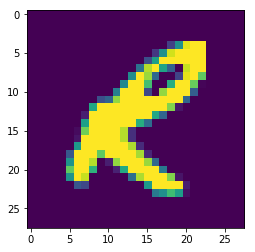

In [14]:
import string 

test_acc1 = sess.run([accuracy], feed_dict={x: X_test,y : Y_test})
print("Testing Accuracy:","{}".format(test_acc1))
t = list(string.ascii_uppercase)
print("prediction:")
p = tf.argmax(tf.nn.softmax(pred),1)
print("estimate: ",t[int(sess.run(p,feed_dict={x:X_test[:1]}))])
print("true image")
plt.imshow(X_test[0].reshape(28,28))
plt.show()
#print(Y_test[0])

summary_writer.close()